# Ichise2002Vasc for Twilite and Image-Derived Input Functions

## Setup

In [1]:
# system functions that are always useful to have
import time, sys, os
from pprint import pprint

try:
    import numpy as np
    print("numpy is available")  # numpy is available; Jupyter linter has an issue with numpy
except ImportError:
    print("numpy is not available")
# import numpy as np 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


numpy is available


In [2]:
from PETUtilities import PETUtilities
from IOImplementations import BaseIO
from RBCPartition import RBCPartition
from InputFuncData import InputFuncData
from Ichise2002VascContext import Ichise2002VascContext

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# everything is decay corrected

kerndir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "kernels")
kern = os.path.join(kerndir, "kernel_hct=46.8.nii.gz")

fdgdir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "ses-20210421155709", "pet")
pet = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames_timeAppend-165-ParcSchaeffer-reshape-to-schaeffer-schaeffer.nii.gz")

# no deconv., decay corrected, no recovery coefficient
idif_embed = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-MipIdif_idif.nii.gz")
# deconv., decay corrected, no recovery coefficient
idif_deconv = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-MipIdif_idif-BoxcarIO-ideal.nii.gz")
idif = InputFuncData.nii_hstack(idif_deconv, idif_embed, t_crossover=300, output_format="fqfn")

# no deconv., decaying, measurements corrected to draw-times
twil_embed = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-TwiliteKit-do-make-input-func-nomodel_inputfunc-embed.nii.gz")
# deconv., decaying, measurements corrected to draw-times, duration ~ 470 sec
twil_deconv = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-TwiliteKit-do-make-input-func-nomodel_inputfunc-RadialArteryIO-ideal.nii.gz")
twil = InputFuncData.nii_hstack(twil_deconv, twil_embed, t_crossover=300, output_format="fqfn")
twil = InputFuncData.decay_correct(twil, output_format="fqfn")

codir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "ses-20210421144815", "pet")
v1_idif = os.path.join(codir, "sub-108293_ses-20210421144815_trc-co_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames-ParcSchaeffer-reshape-to-schaeffer-schaeffer-idif_martinv1.nii.gz")
v1_twil = os.path.join(codir, "sub-108293_ses-20210421144815_trc-co_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames-ParcSchaeffer-reshape-to-schaeffer-schaeffer-twilite_martinv1.nii.gz")

parc_index = 25  # caudate ~ 26 (Matlab); thalamus ~ 6, 25 (Matlab)

RBCPartition t_crossover: 35


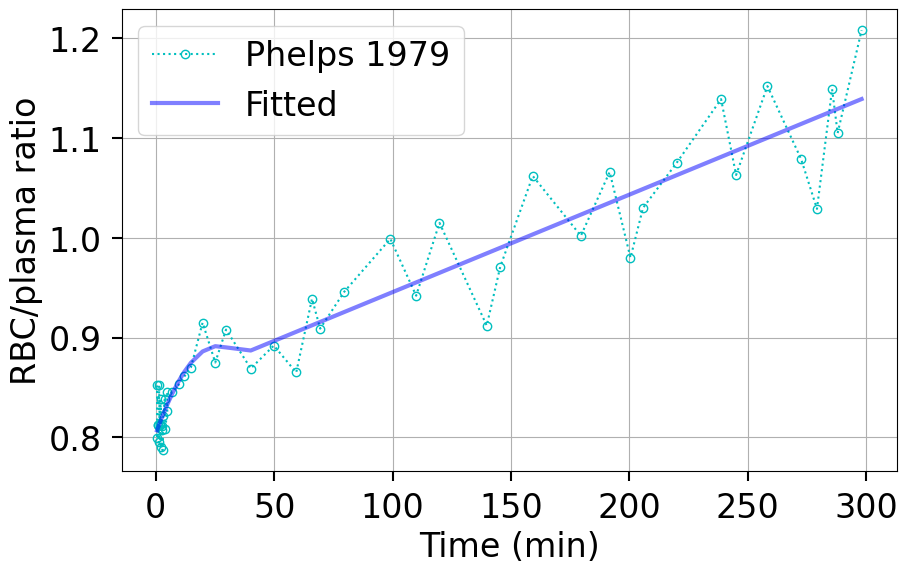

In [4]:
rbcp = RBCPartition(hct=46.8)
print(f"RBCPartition t_crossover: {rbcp.t_crossover}")
rbcp.plot()

## Inspect Ichise2002VascContext twil

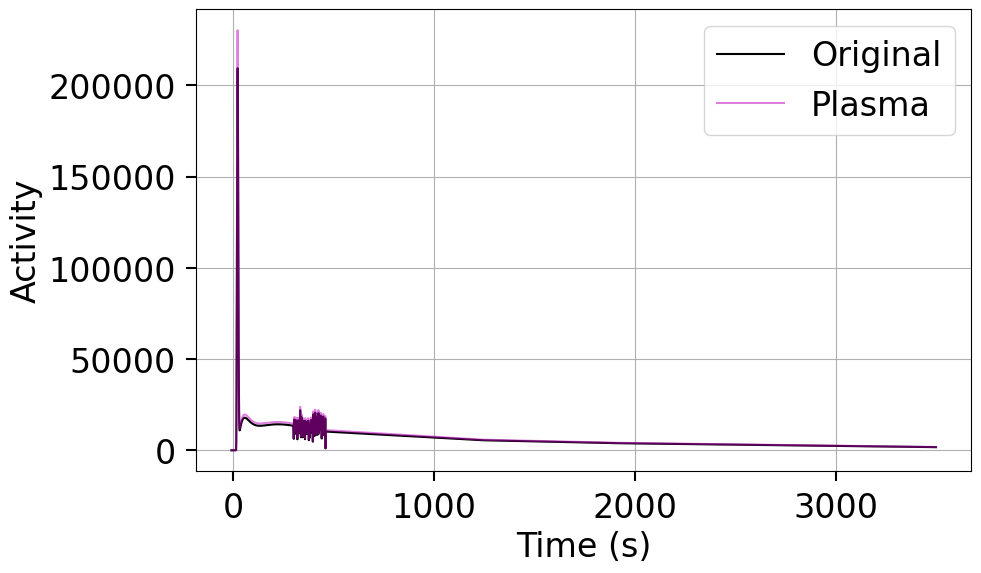

(474,)
'AUC: 22796288.208033822'


In [5]:
twil0 = BaseIO().nii_load(twil)
twil1 = rbcp.nii_wb2plasma(twil, output_format="niid")
twilp = rbcp.nii_wb2plasma(twil, output_format="fqfn")
plt.figure(figsize=(10,6))
plt.plot(twil0["timesMid"], twil0["img"], 'k-', label='Original')
plt.plot(twil1["timesMid"], twil1["img"], 'm-', alpha=0.5, label='Plasma')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.grid(True)
plt.legend()
plt.show()

pprint(twil1["img"].shape)
auc = np.trapezoid(twil1["img"], twil1["timesMid"])
pprint(f"AUC: {auc}")

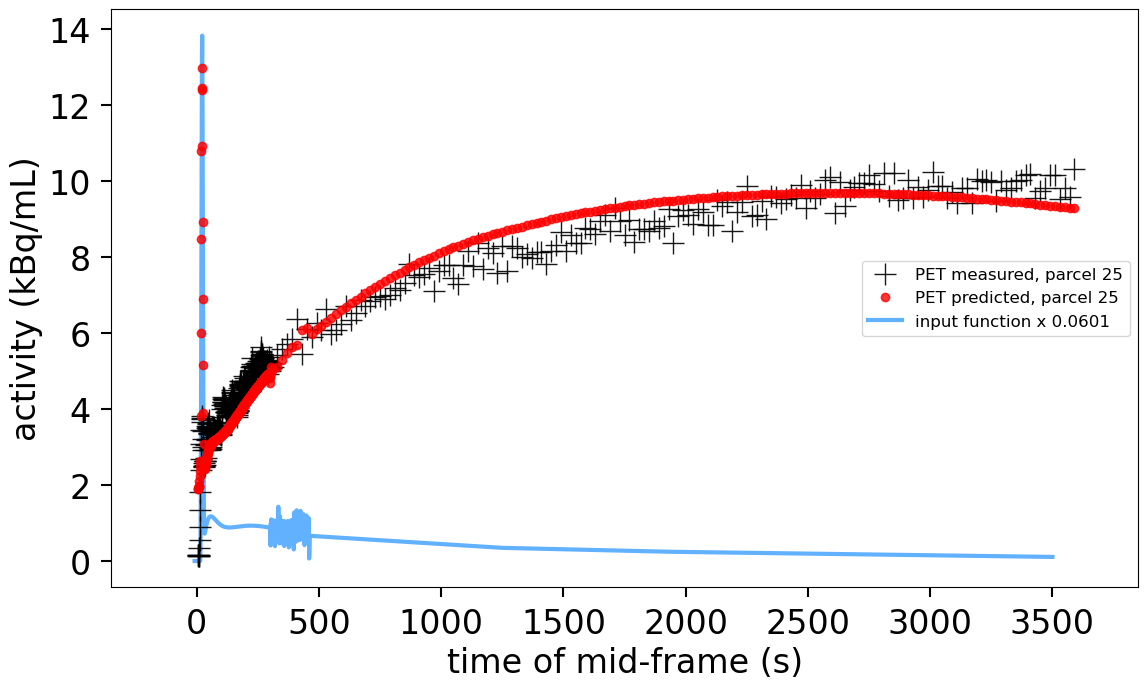

In [6]:
data_dict_twil = {
    "kernel_fqfn": kern,
    "input_func_fqfn": twilp,
    "tissue_fqfn": pet,
    "v1_fqfn": v1_twil,
    "delta_time": 10,
    "nlive": 100,
    "tag": "playground_Ichise2002Vasc_twil"
}
truth_Ichise2002Vasc_twil = [    
    1.94400221e+01, 6.32153881e-03, 3.18920600e+01, 2.61690126e-01,
    1.54129159e+01, 5.00936472e-03, 5.49191466e-02, 8.04165361e-02
]
Ichise2002Vasc_twil = Ichise2002VascContext(data_dict_twil)
Ichise2002Vasc_twil.plotting.truths_plot(truths=truth_Ichise2002Vasc_twil, parc_index=parc_index)

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [7]:
res_twil = Ichise2002Vasc_twil.solver.run_nested(print_progress=True, parc_index=parc_index)

20008it [06:29, 51.33it/s, batch: 21 | bound: 13 | nc: 1 | ncall: 1400199 | eff(%):  1.421 | loglstar: 510.954 < 516.462 < 514.691 | logz: 480.802 +/-  0.202 | stop:  0.999]                 


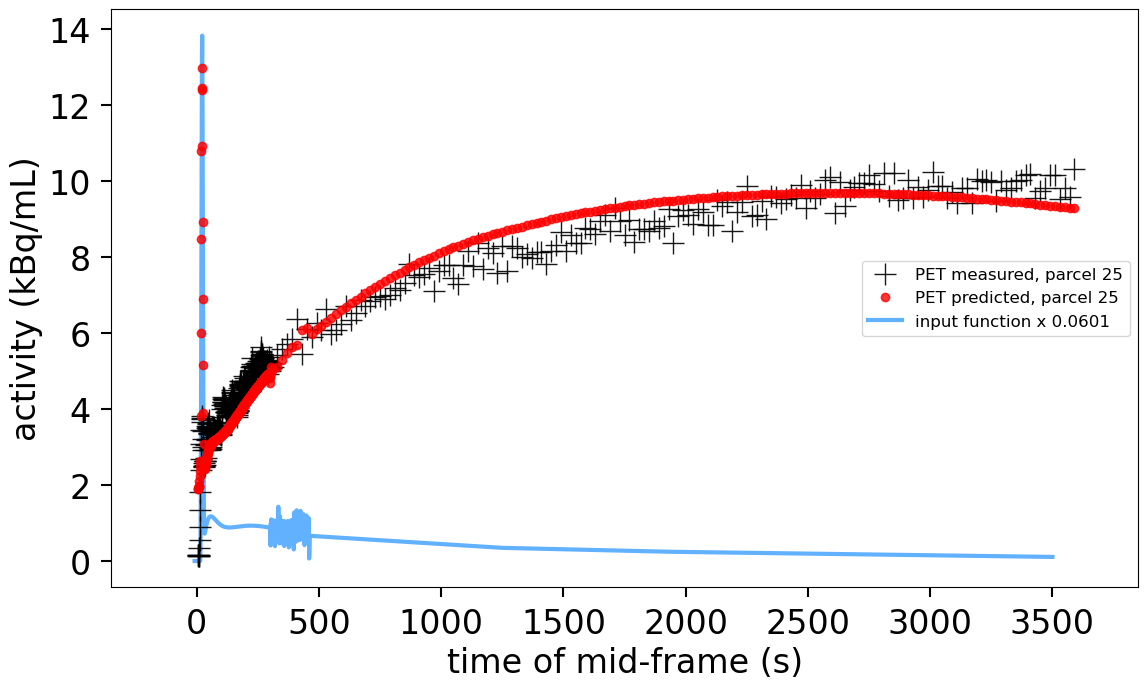

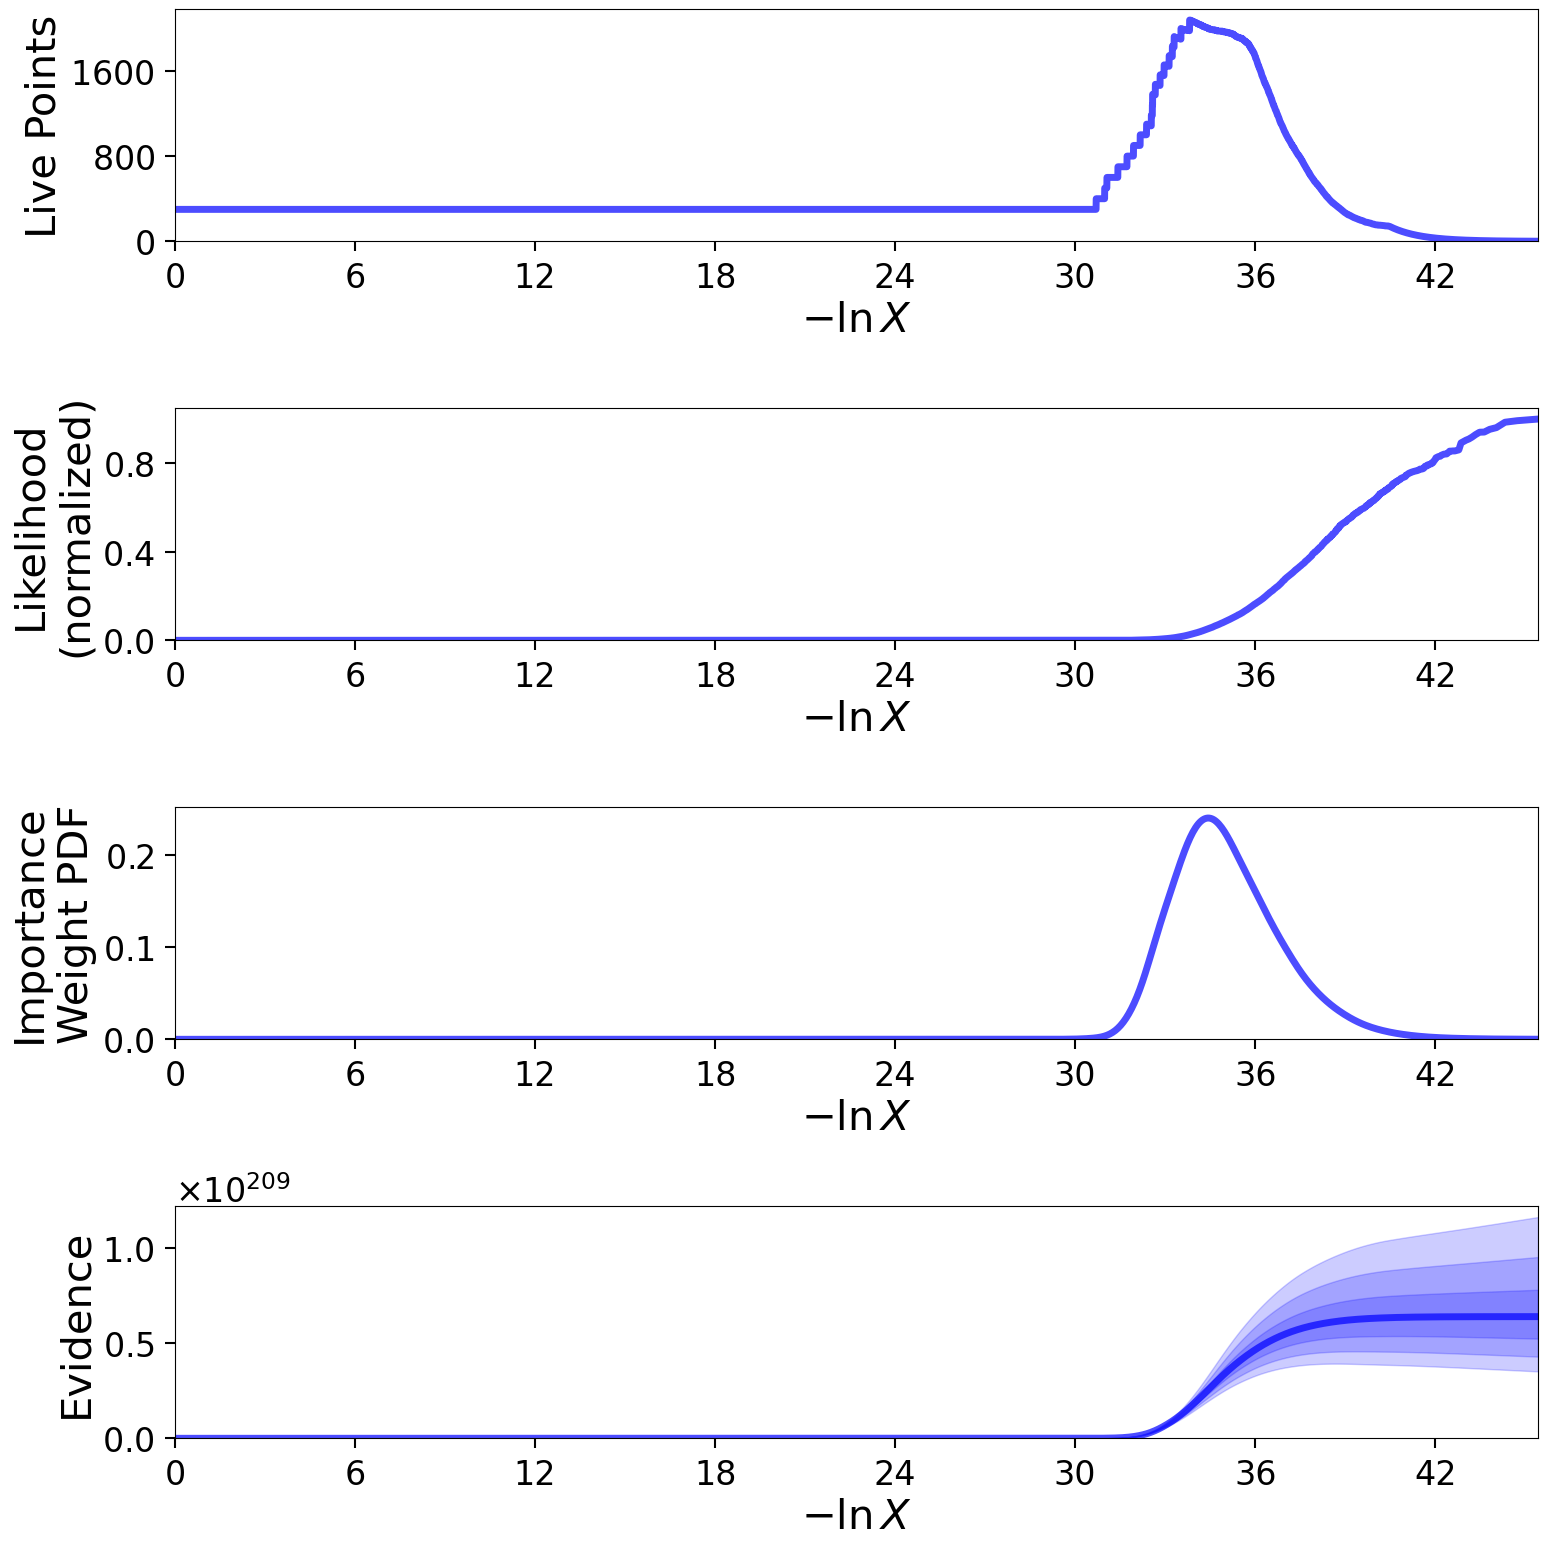

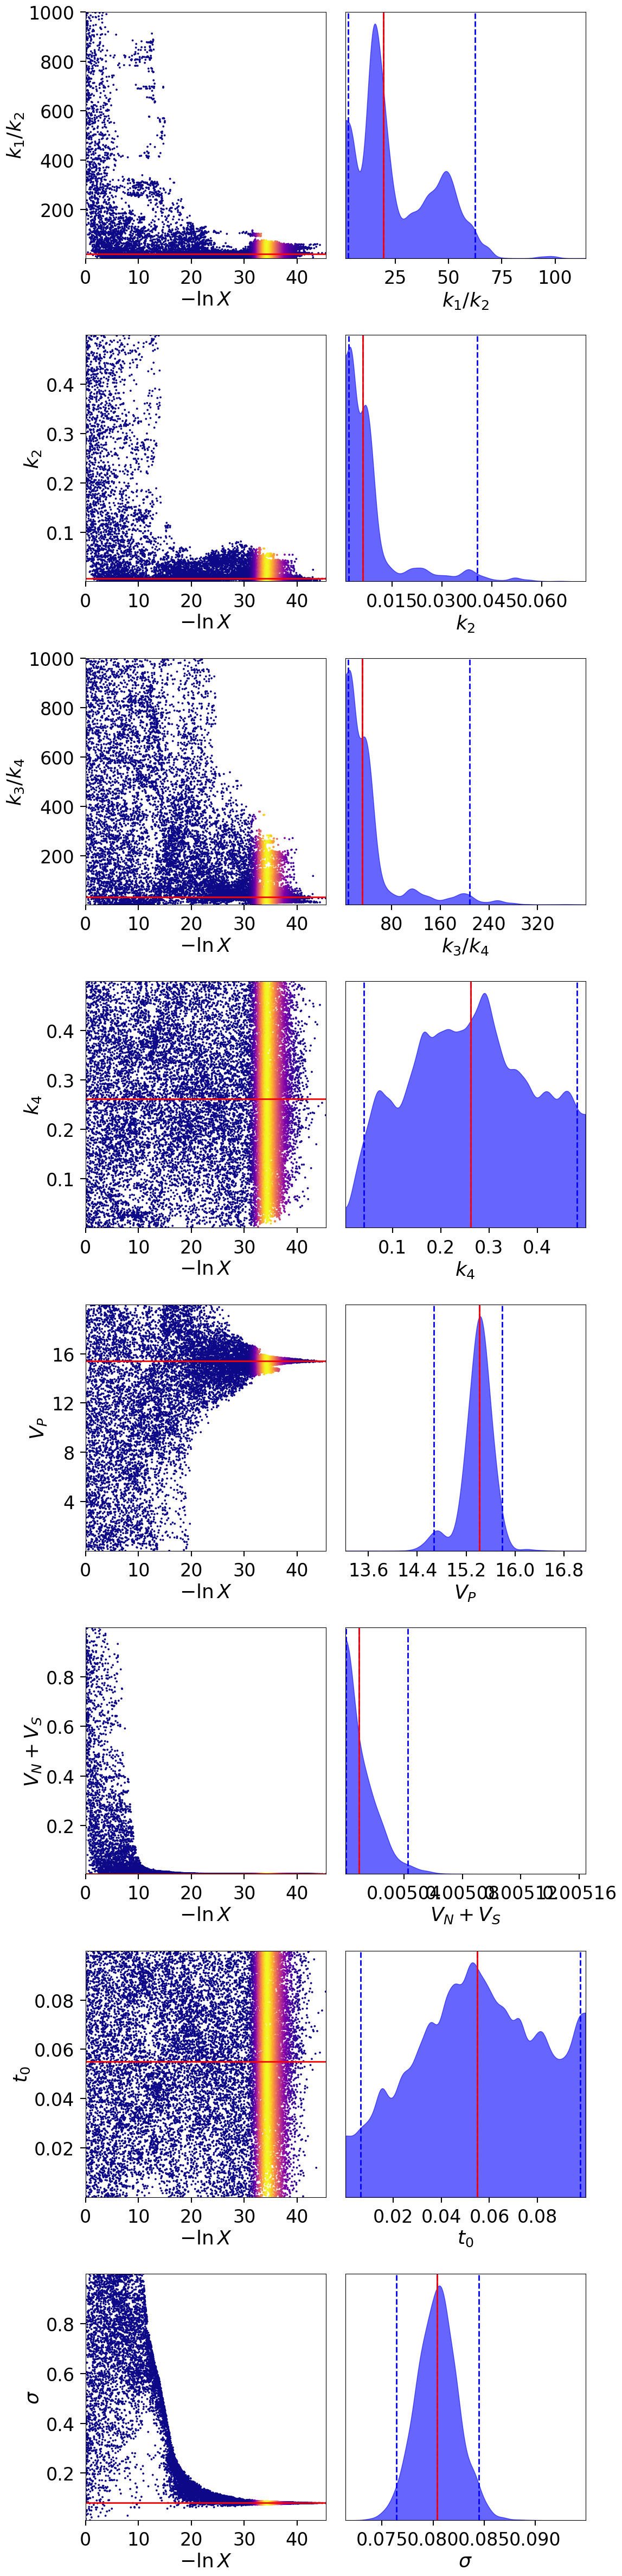

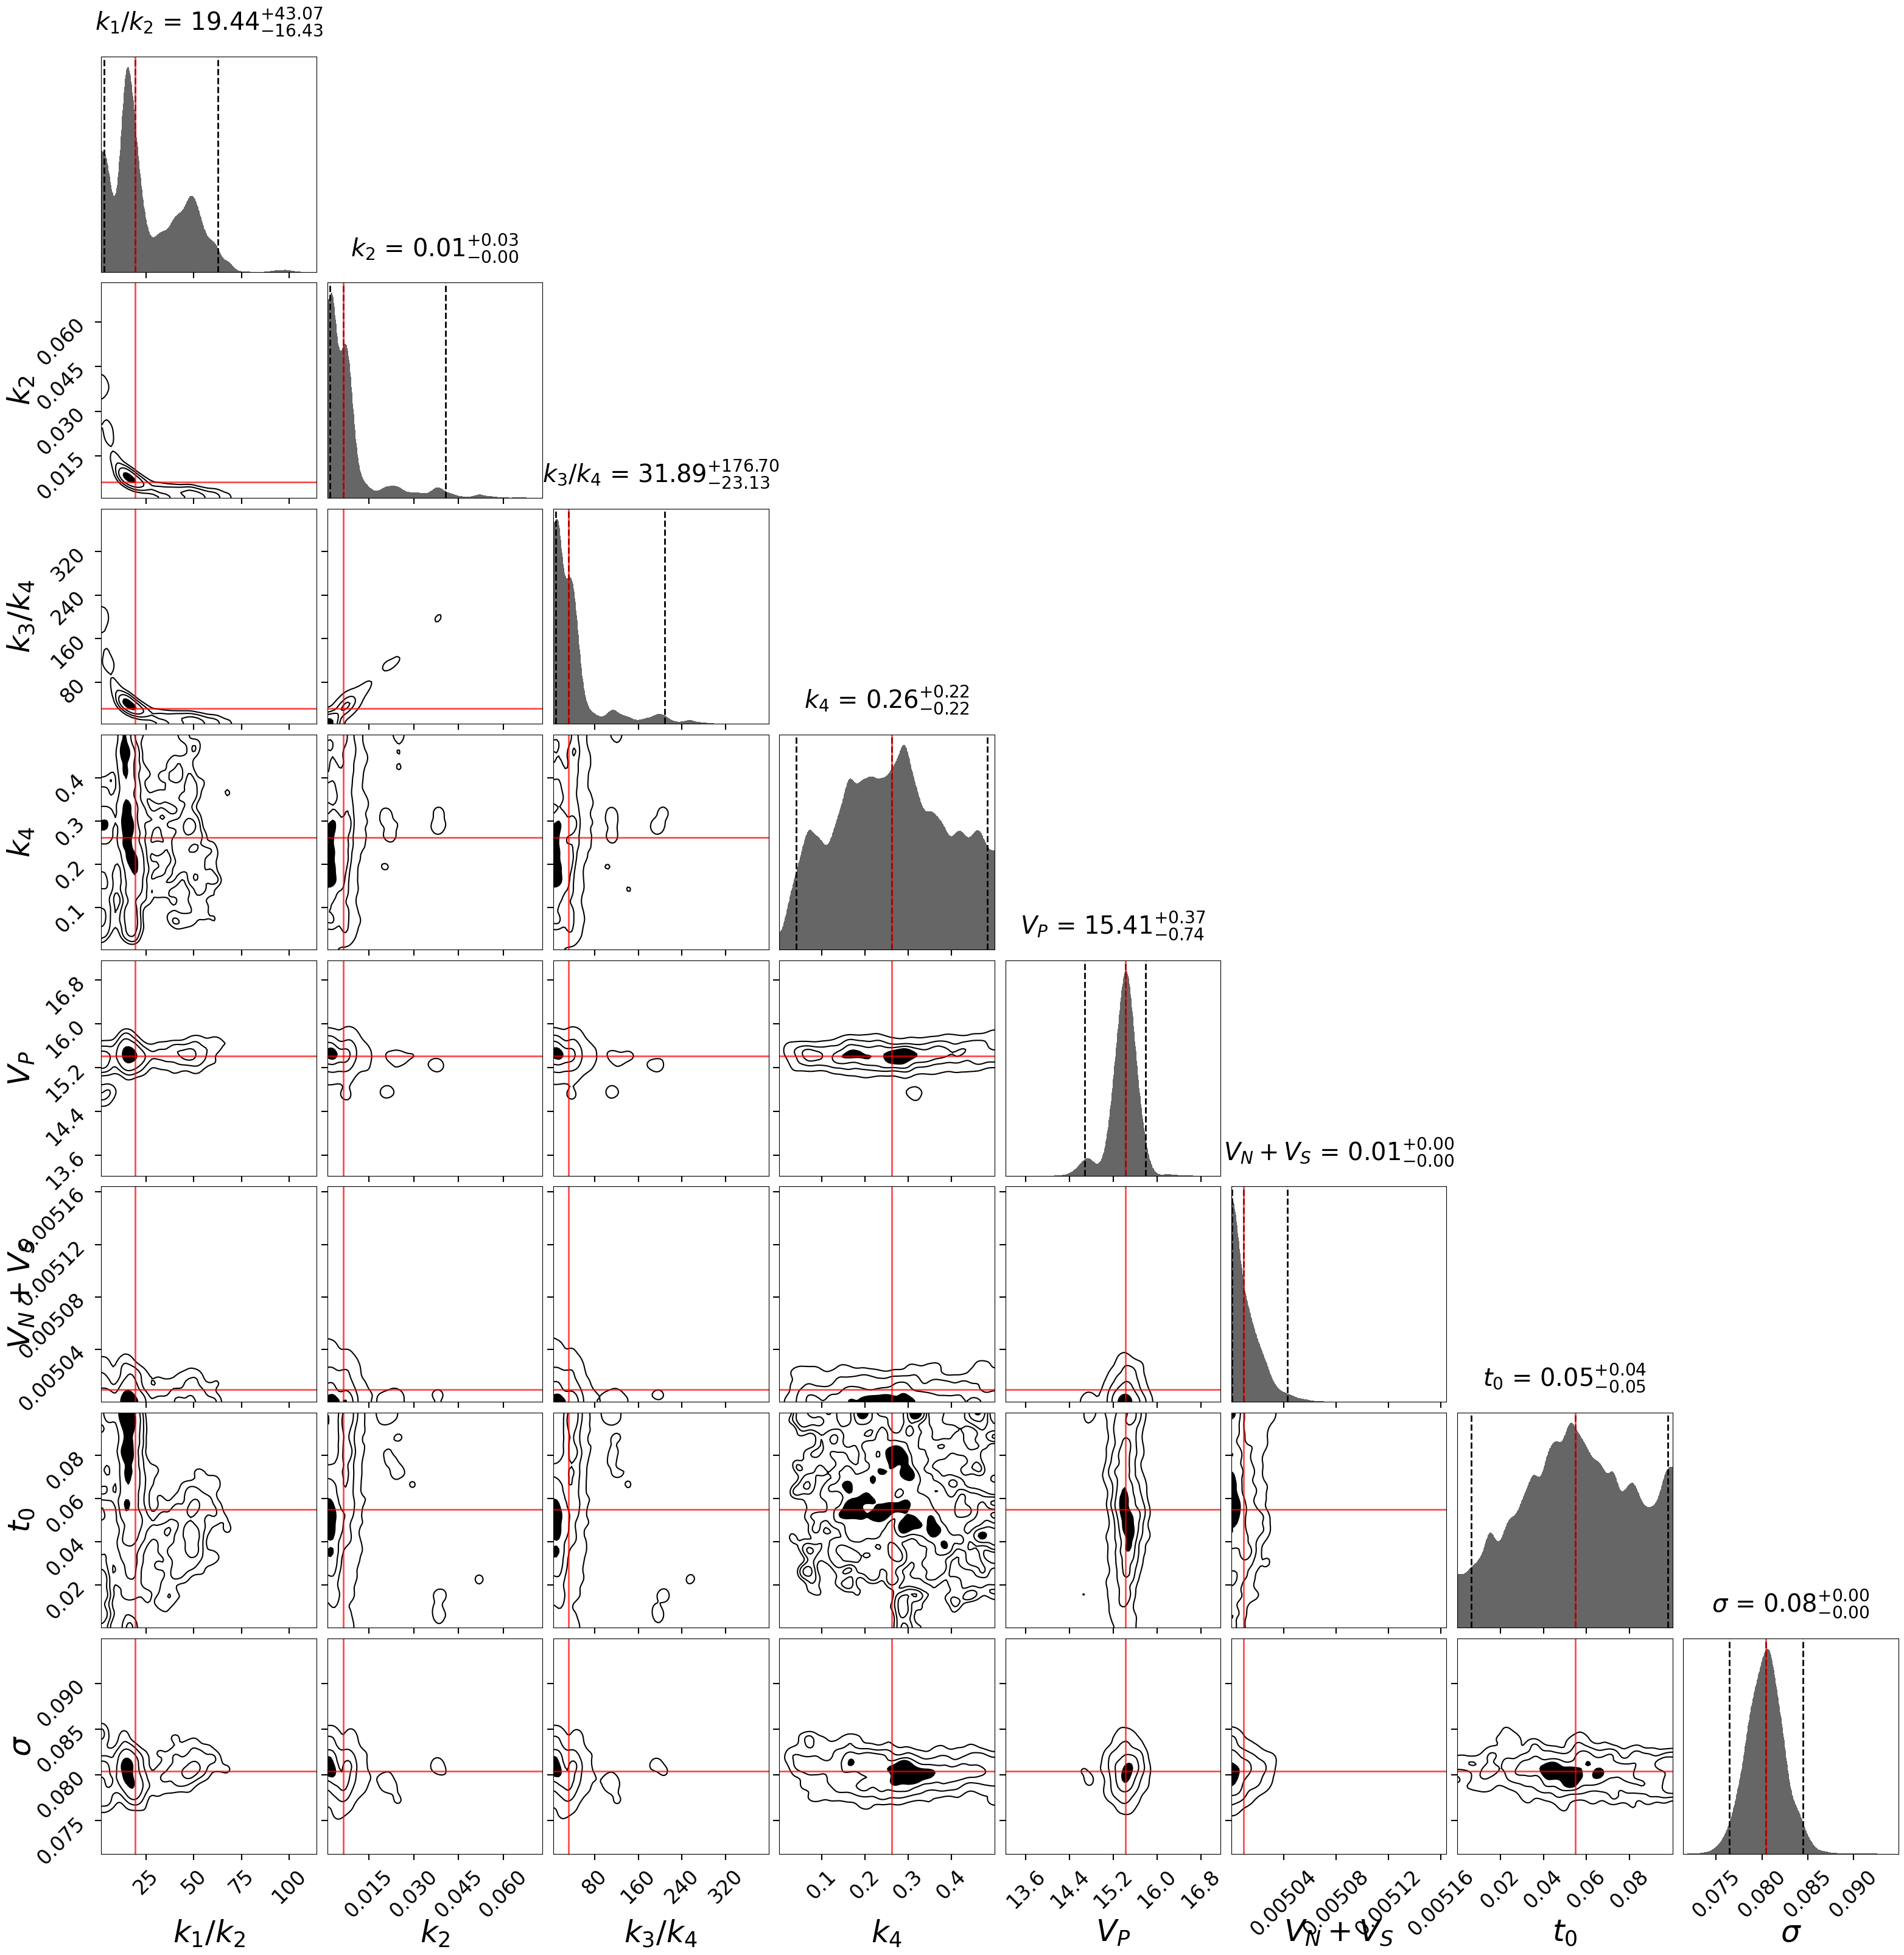

In [8]:
Ichise2002Vasc_twil.plotting.results_plot(tag="playground_Ichise2002Vasc_twil", parc_index=parc_index)

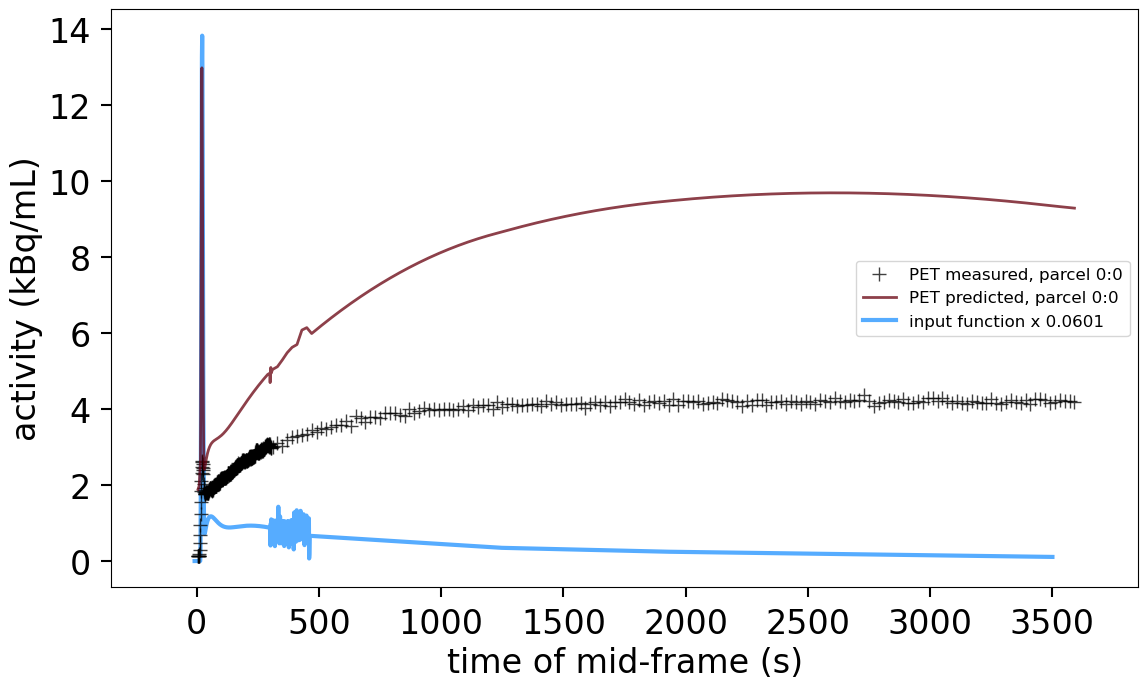

In [9]:
Ichise2002Vasc_twil.plotting.parcs_plot()

## Inspect Ichise2002VascContext idif

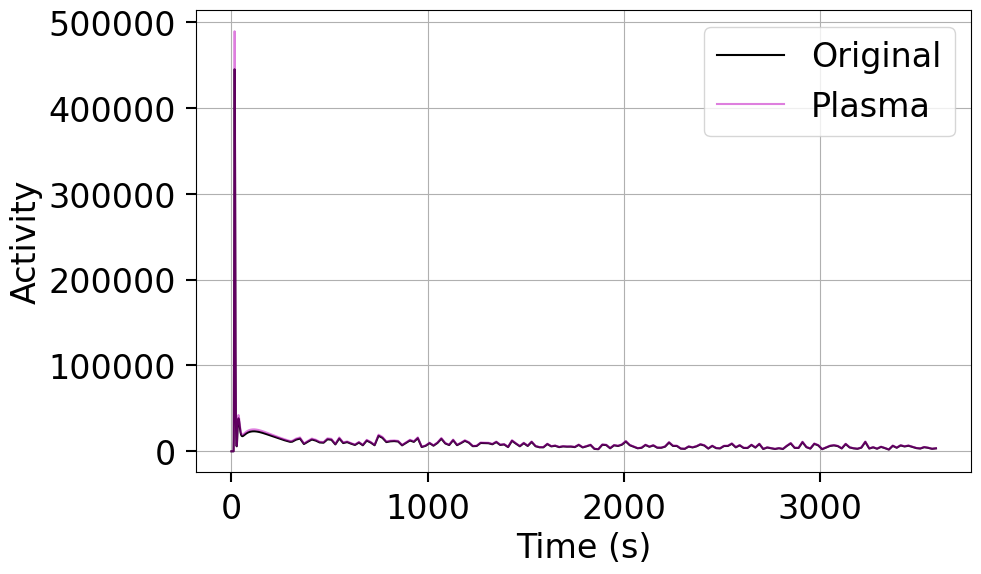

(465,)
'AUC: 18233441.47053301'


In [10]:
idif0 = BaseIO().nii_load(idif)
idif1 = rbcp.nii_wb2plasma(idif, output_format="niid")
idifp = rbcp.nii_wb2plasma(idif, output_format="fqfn")
plt.figure(figsize=(10,6))
plt.plot(idif0["timesMid"], 1.8509 * idif0["img"], 'k-', label='Original')
plt.plot(idif1["timesMid"], 1.8509 * idif1["img"], 'm-', alpha=0.5, label='Plasma')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.grid(True)
plt.legend()
plt.show()

pprint(idif1["img"].shape)
auc = np.trapezoid(idif1["img"], idif1["timesMid"])
pprint(f"AUC: {auc}")

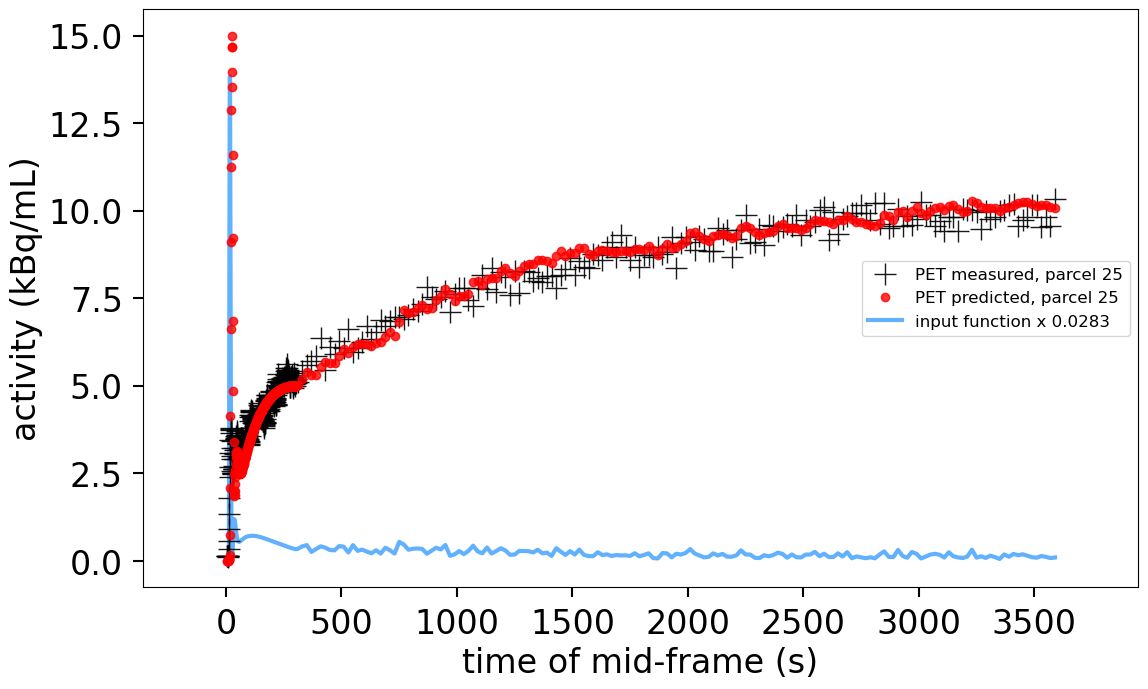

In [11]:
data_dict_idif = {
    "input_func_fqfn": idifp,
    "tissue_fqfn": pet,
    "v1_fqfn": v1_idif,
    "delta_time": 10,
    "nlive": 100,
    "tag": "playground_Ichise2002Vasc_idif"
}
truth_Ichise2002Vasc_idif = [
    7.24399748e+01, 2.50025073e-03, 5.81372240e+00, 3.57070760e-04,
    7.99647580e+00, 5.00683229e-03, 5.09453751e-02, 1.09459335e-01
]

Ichise2002Vasc_idif = Ichise2002VascContext(data_dict_idif)
Ichise2002Vasc_idif.plotting.truths_plot(truths=truth_Ichise2002Vasc_idif, parc_index=parc_index)

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [12]:
res_idif = Ichise2002Vasc_idif.solver.run_nested(print_progress=True, parc_index=parc_index)

1183it [00:14, 51.68it/s, batch: 0 | bound: 33 | nc: 55 | ncall: 71094 | eff(%):  1.662 | loglstar:   -inf < -369.649 <    inf | logz: -385.544 +/-  0.779 | dlogz: 313.547 >  0.010]         /Users/jjlee/anaconda3/envs/dynesty12/lib/python3.12/site-packages/dynesty/sampling.py:420: UserWarning: The slice sample interval was expanded more than 1000 times
  warnings.warn('The slice sample interval was expanded more '
/Users/jjlee/anaconda3/envs/dynesty12/lib/python3.12/site-packages/dynesty/sampling.py:685: UserWarning: Enabling doubling strategy of slice sampling from Neal(2003)
  warnings.warn('Enabling doubling strategy of slice '
22580it [06:14, 60.23it/s, batch: 18 | bound: 31 | nc: 1 | ncall: 1927623 | eff(%):  1.166 | loglstar: 354.212 < 373.117 < 371.348 | logz: 320.060 +/-  0.239 | stop:  0.964]          


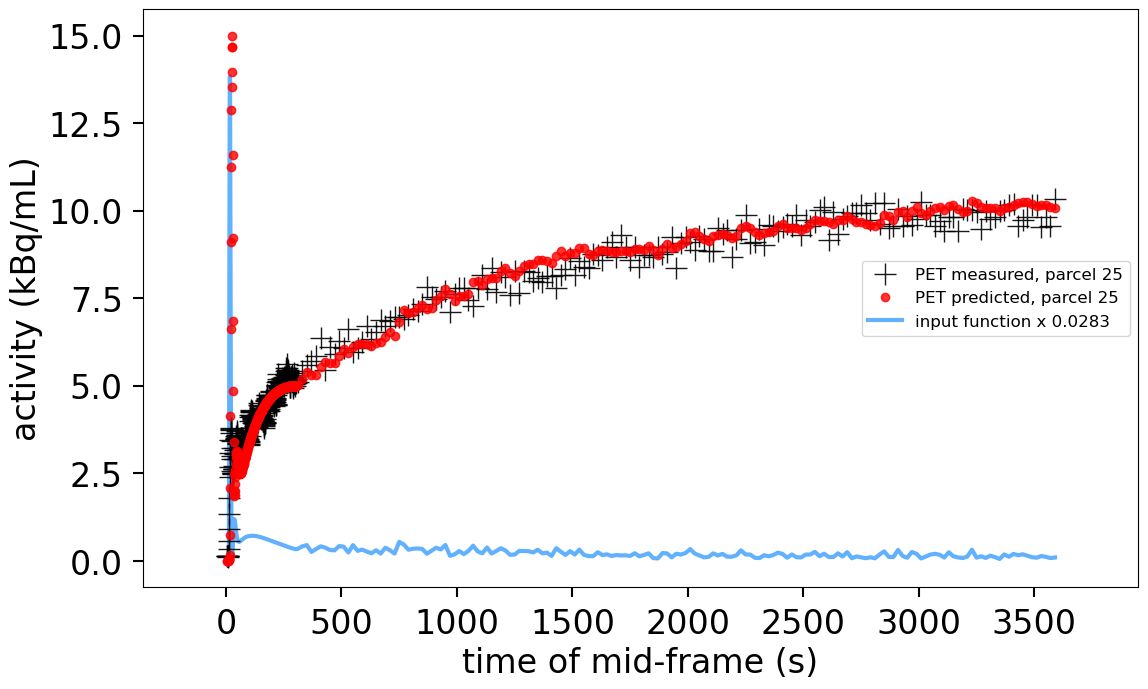

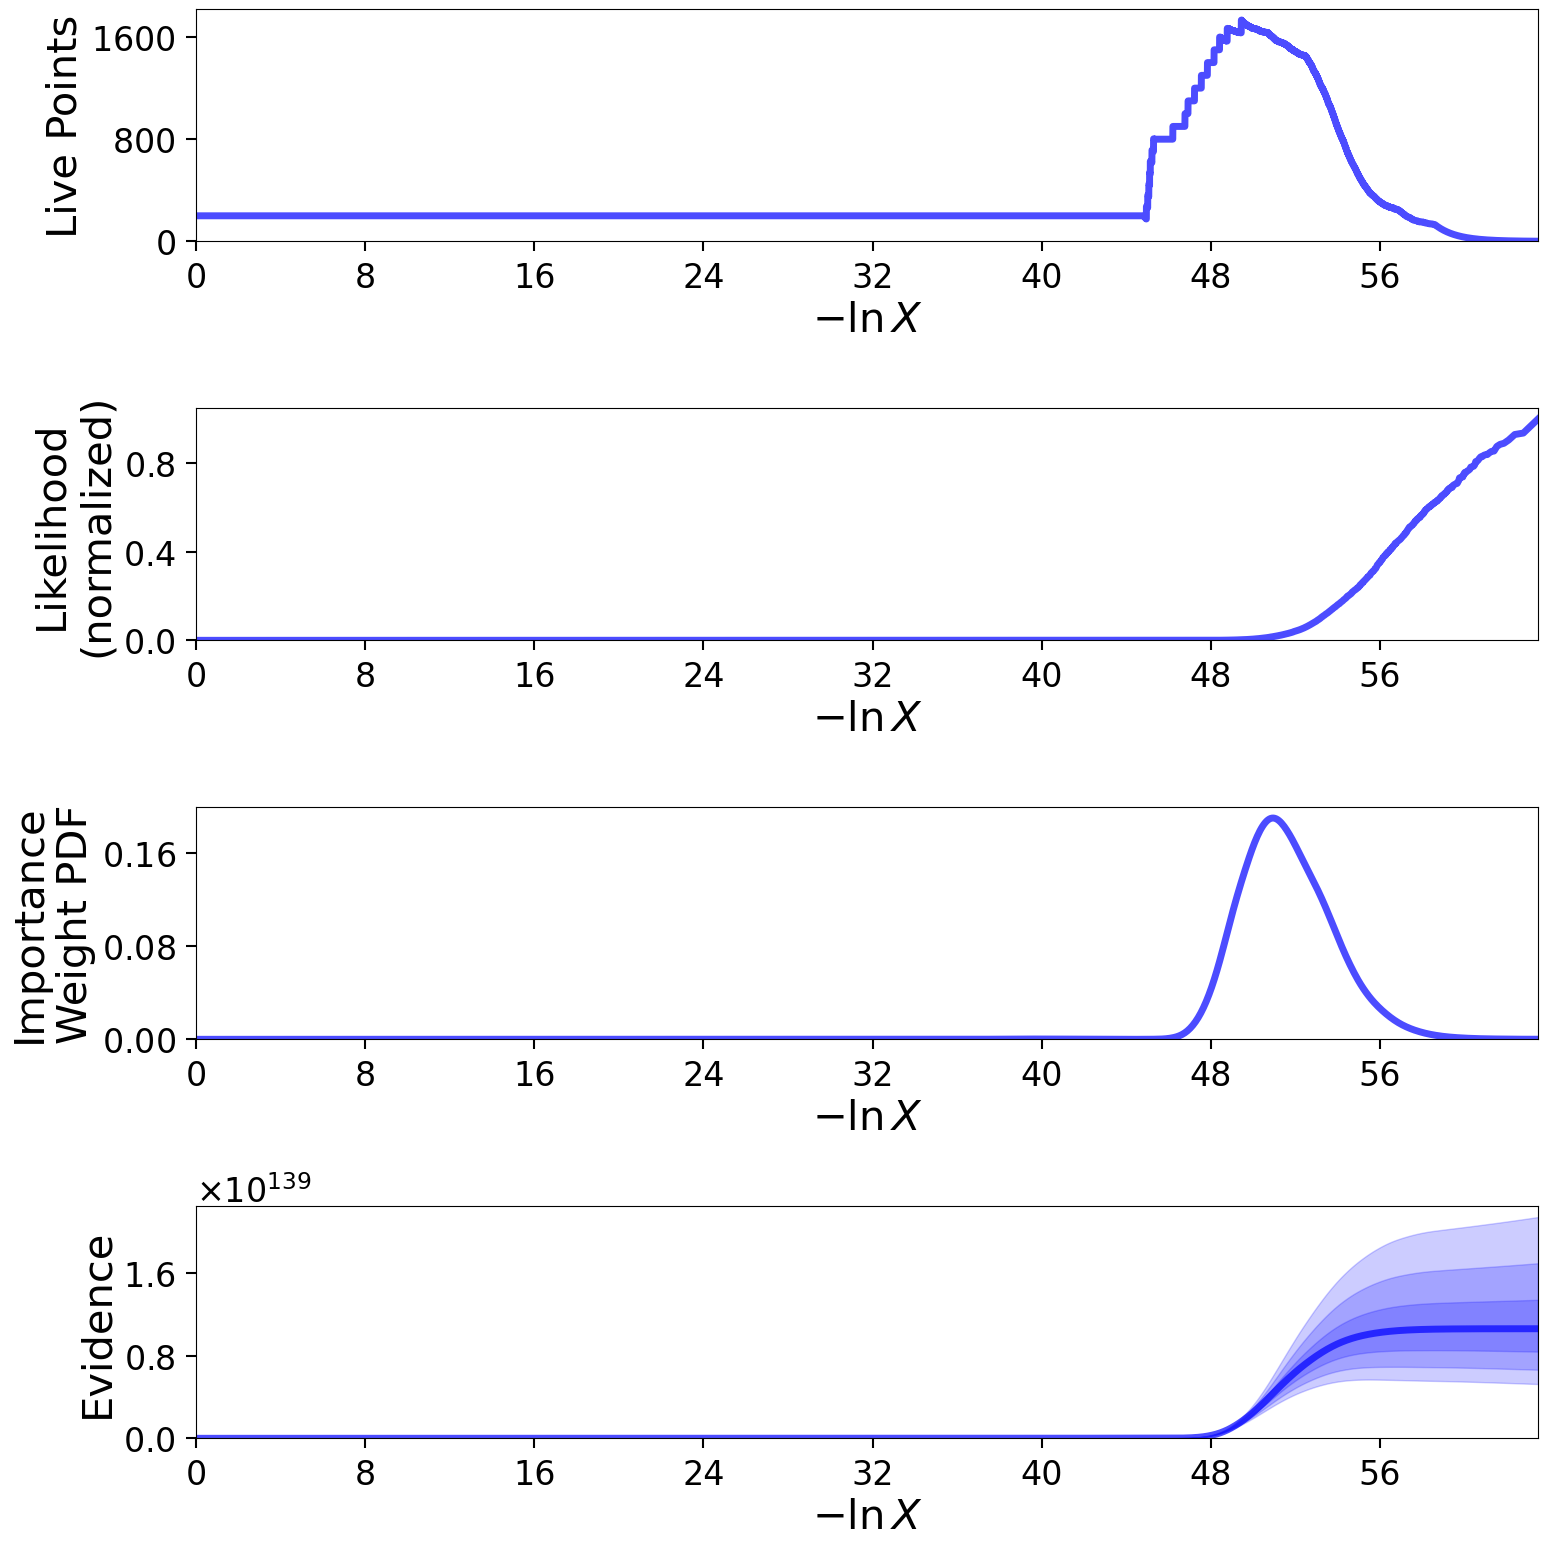

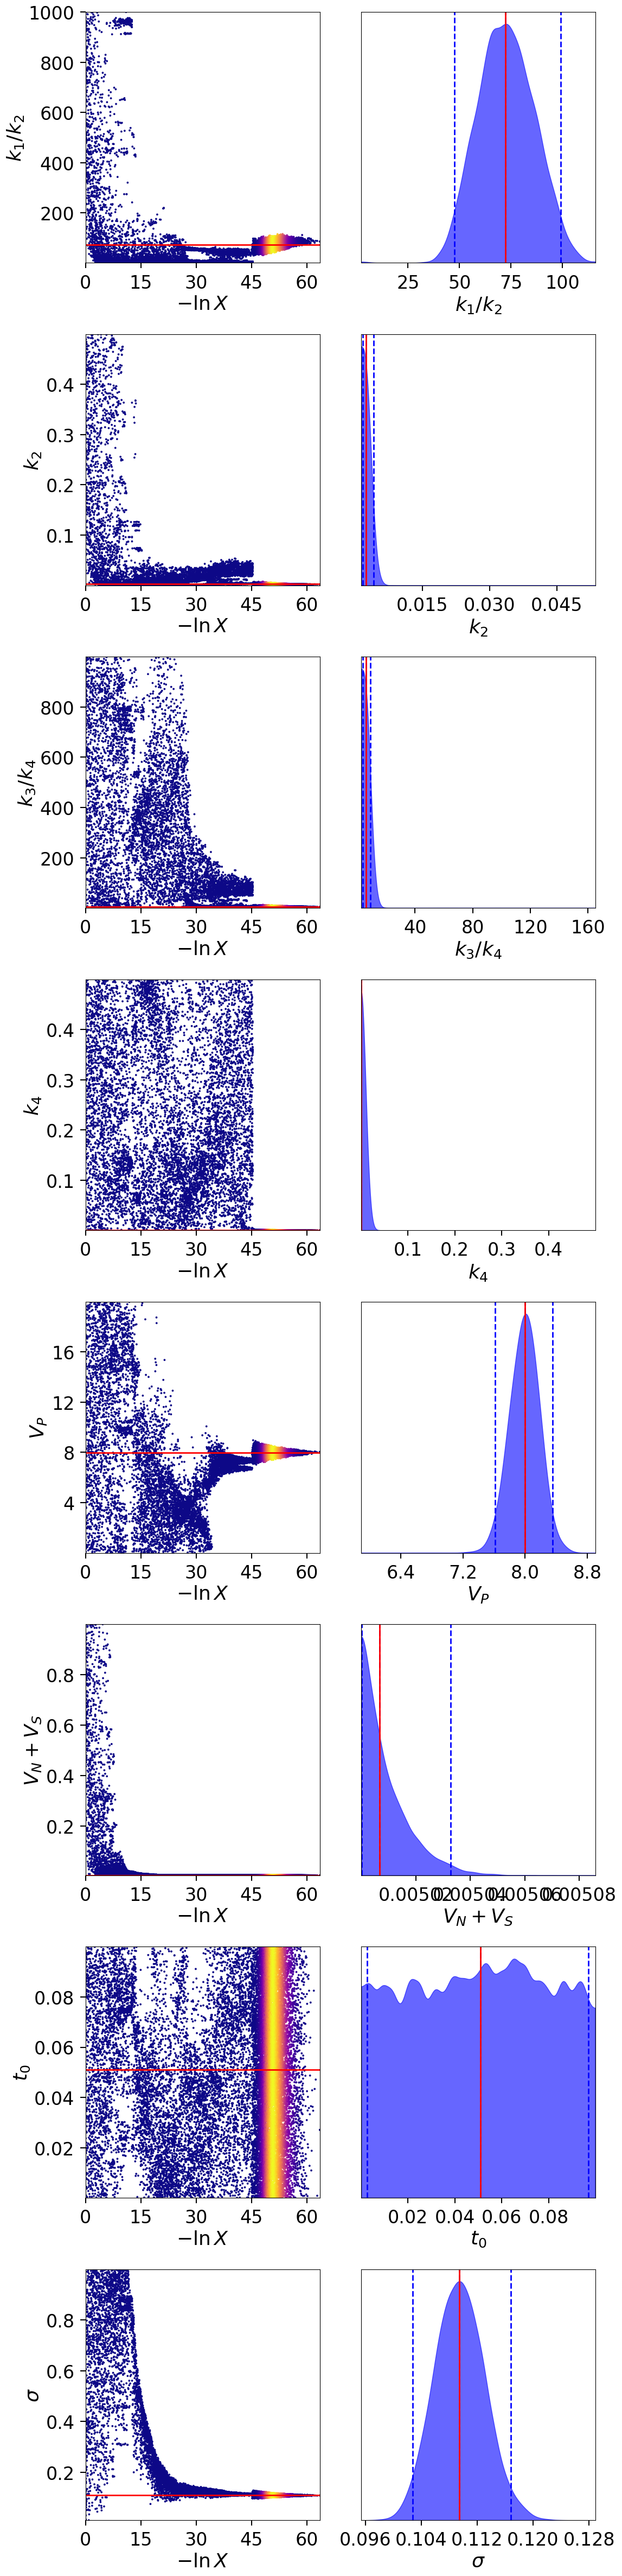

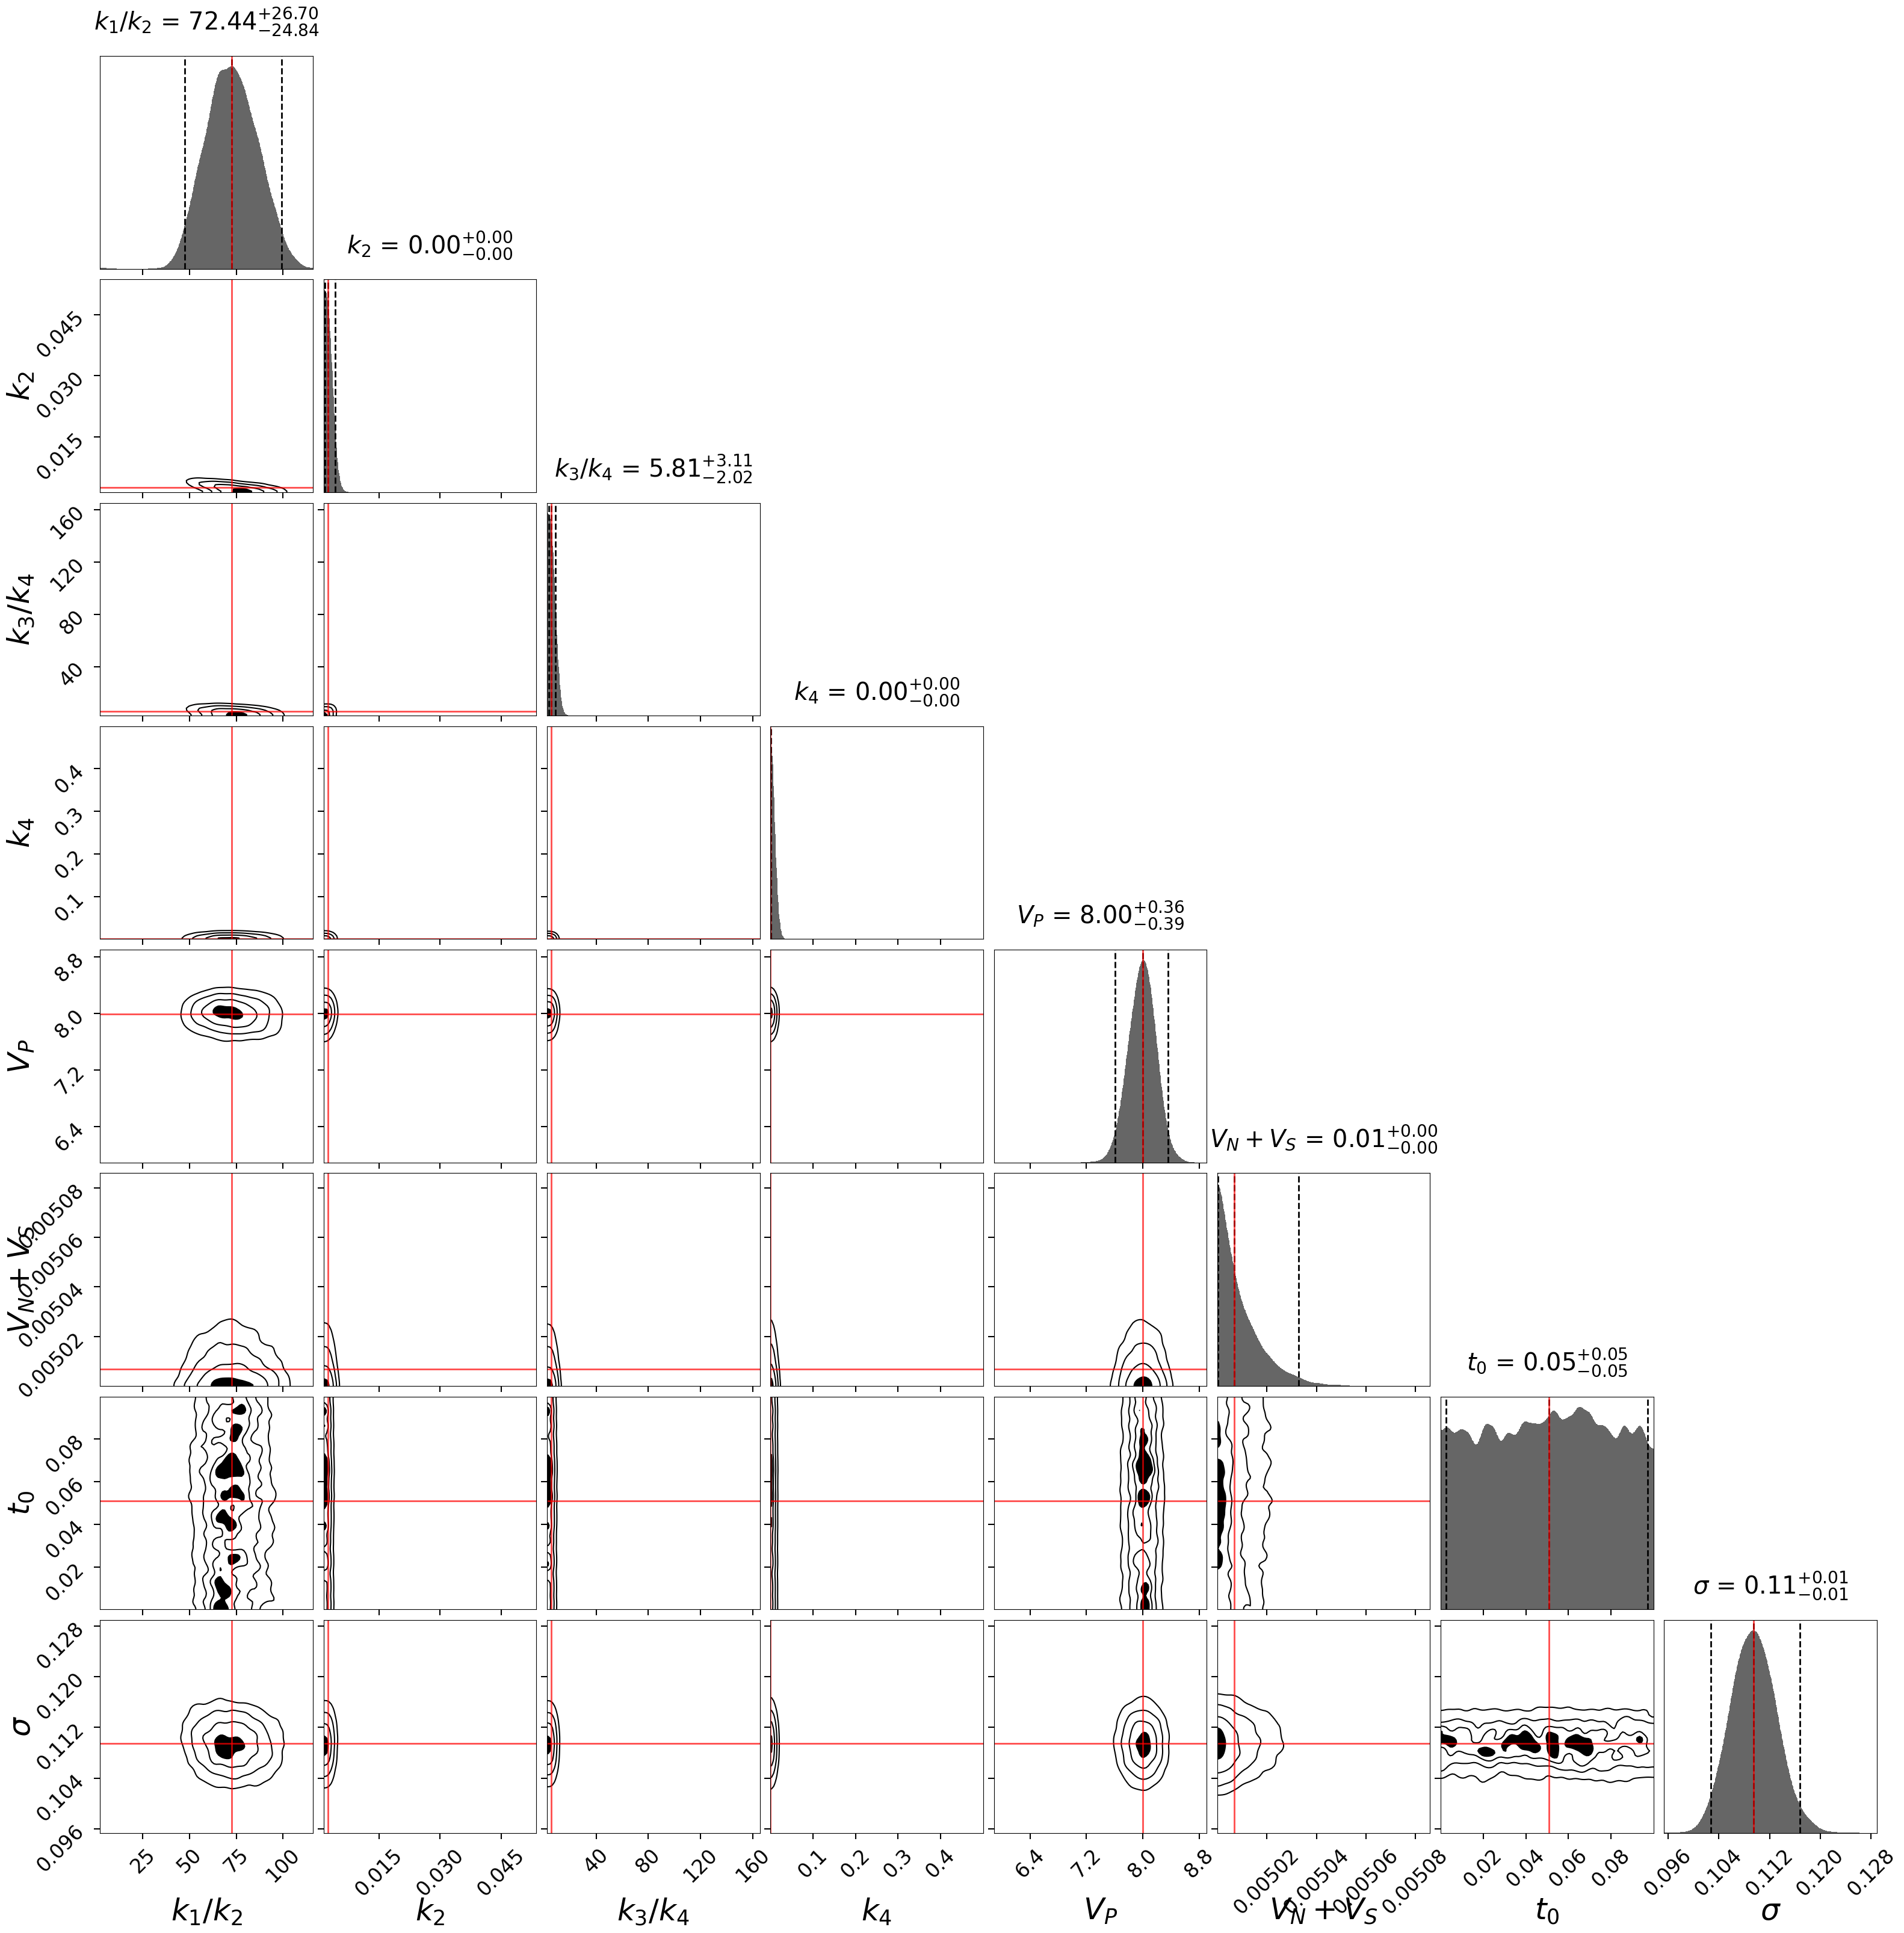

In [13]:
Ichise2002Vasc_idif.plotting.results_plot(tag="playground_Ichise2002Vasc_idif", parc_index=parc_index)

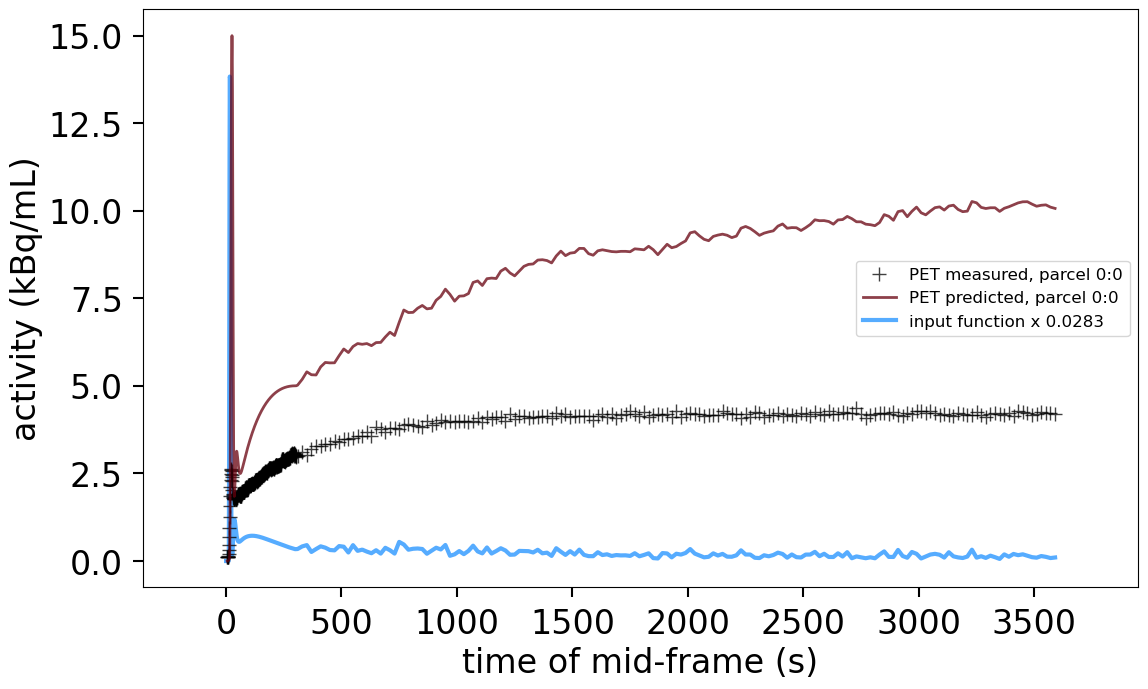

In [14]:
Ichise2002Vasc_idif.plotting.parcs_plot()

In [15]:
Ichise2002Vasc_twil.data.print_truths()
Ichise2002Vasc_idif.data.print_truths()



=============================== Truths ===============================
Parameter                        Value
----------------------------------------
$k_1/k_2$                     19.44002
$k_2$                          0.00632
$k_3/k_4$                     31.89206
$k_4$                          0.26169
$V_P$                         15.41292
$V_N + V_S$                    0.00501
$t_0$                          0.05492
$\sigma$                       0.08042


=============================== Truths ===============================
Parameter                        Value
----------------------------------------
$k_1/k_2$                     72.43997
$k_2$                          0.00250
$k_3/k_4$                      5.81372
$k_4$                          0.00036
$V_P$                          7.99648
$V_N + V_S$                    0.00501
$t_0$                          0.05095
$\sigma$                       0.10946


In [16]:
pprint(Ichise2002Vasc_twil.solver.truths)
pprint(Ichise2002Vasc_idif.solver.truths)

array([1.94400221e+01, 6.32153881e-03, 3.18920600e+01, 2.61690126e-01,
       1.54129159e+01, 5.00936472e-03, 5.49191466e-02, 8.04165361e-02])
array([7.24399748e+01, 2.50025073e-03, 5.81372240e+00, 3.57070760e-04,
       7.99647580e+00, 5.00683229e-03, 5.09453751e-02, 1.09459335e-01])
